## Time Series Analysis: BHP.AX Returns

#### BHP price action from 1/07/2021 - 28/09/2023 with dividends added to adjusted close

In [ ]:
#!pip install Numpy==1.23.5 --user
# ' module 'numpy' has no attribute 'MachAr''

In [2]:
# Required Packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# Incase of deprecated alias
#np.float = float    
#np.int = int   #module 'numpy' has no attribute 'int'
#np.object = object    #module 'numpy' has no attribute 'object'
#np.bool = bool    #module 'numpy' has no attribute 'bool'
#np.long = np.longlong

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scs


D:\PythonUOW\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Import Excel file

df=pd.read_csv(r"C:\Users\New User\Desktop\BHP.AX.csv")


In [4]:
#### View data set
print(df)

           Date  dividend      Close  Adj Close  AdjDiv   return logreturn
0     1/07/2021      0.00  48.220001  38.393768   48.22   0.684%    0.296%
1     2/07/2021      0.00  48.549999  38.656521   48.55  -0.206%   -0.090%
2     5/07/2021      0.00  48.450001  38.576900   48.45   0.826%    0.357%
3     6/07/2021      0.00  48.849998  38.895386   48.85  -0.102%   -0.044%
4     7/07/2021      0.00  48.799999  38.855572   48.80   1.762%    0.759%
..          ...       ...        ...        ...     ...      ...       ...
563  26/09/2023      7.41  43.299999  43.299999   50.71   0.439%    0.162%
564  27/09/2023      7.41  43.490002  43.490002   50.90   0.552%    0.204%
565  28/09/2023      7.41  43.730000  43.730000   51.14   1.189%    0.439%
566         NaN       NaN        NaN        NaN     NaN      NaN       NaN
567         NaN       NaN        NaN        NaN     NaN      NaN       NaN

[568 rows x 7 columns]


In [5]:
# Format Date column
df['Date'] = pd.to_datetime(df['Date'], format= "%d/%m/%Y")

df.set_index(['Date'],drop=True) # set drop = True to avoid duplicate date column
print(df.head())

# convert percentages into floats 
df['logreturn'] = df['logreturn'].str.rstrip('%').astype('float') / 100.0

        Date  dividend      Close  Adj Close  AdjDiv   return logreturn
0 2021-07-01       0.0  48.220001  38.393768   48.22   0.684%    0.296%
1 2021-07-02       0.0  48.549999  38.656521   48.55  -0.206%   -0.090%
2 2021-07-05       0.0  48.450001  38.576900   48.45   0.826%    0.357%
3 2021-07-06       0.0  48.849998  38.895386   48.85  -0.102%   -0.044%
4 2021-07-07       0.0  48.799999  38.855572   48.80   1.762%    0.759%


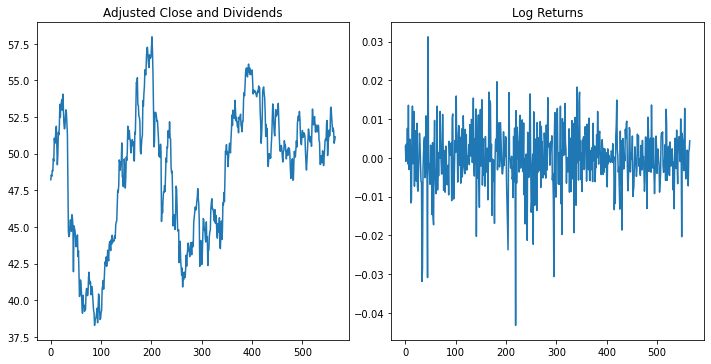

In [6]:


## Visualise Time Series
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout()
ax1.plot(df.AdjDiv)
ax1.set_title('Adjusted Close and Dividends')
ax2.plot(df.logreturn)
ax2.set_title('Log Returns')
plt.show()

The Adjusted close series does not give any discernable features of trend or seasonality from inspection alone. Will require unit root test to see if data is stationary

Log Returns however already looks like white noise, about a mean of zero. Can confirm with unit root test.

In [7]:
# ADF Test
df = df.dropna()
print('AdjDiv ADF Test')
adf_stat, p, _,_,_,_ = sm.tsa.stattools.adfuller(df.AdjDiv)
print('stat=%.3f, p=%.3f' % (adf_stat, p))
if p > 0.05:
    print('Not Stationary at 0.05 significance level')
else:
    print('stationary at 0.05 significane level')
    
print('Log Returns ADF Test')
adf_stat, p, _,_,_,_ = sm.tsa.stattools.adfuller(df.logreturn)
print('stat=%.3f, p=%.3f' % (adf_stat, p))
if p > 0.05:
    print('Not Stationary at 0.05 significance level')
else:
    print('stationary at 0.05 significane level')



AdjDiv ADF Test
stat=-2.194, p=0.209
Not Stationary at 0.05 significance level
Log Returns ADF Test
stat=-23.107, p=0.000
stationary at 0.05 significane level


As expected, the ADF tests are telling us the AdjDiv series is not stationary while the Log Returns are. 

Now we shall do a first order difference on the Adjusted Close series to see if it will become stationary

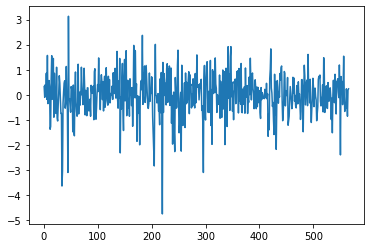

In [8]:
dif1 = sm.tsa.statespace.tools.diff(df.AdjDiv) # default dif is 1

plt.plot(dif1)
plt.show()

In [9]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

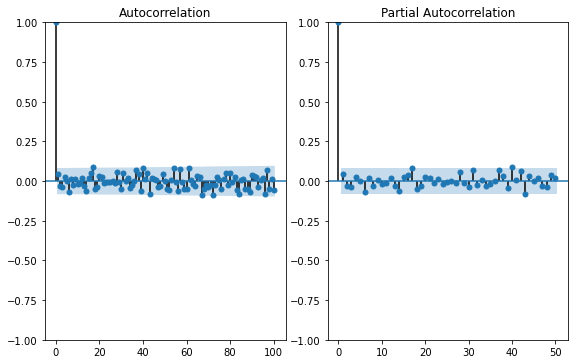

In [10]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.tight_layout()
sm.graphics.tsa.plot_acf(dif1,lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(dif1,lags=50, ax=ax[1])
plt.show()

From inspection, it appears as if the first order difference as turned the Adjusted Closer series into white noise centered around mean zero

Likewise, the ACF and PACF are showing no significant correlations. At this point we are done and can claim that an ARIMA(0,1,0) model is suitable



                               SARIMAX Results                                
Dep. Variable:                 AdjDiv   No. Observations:                  566
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -708.921
Date:                Sun, 28 Jan 2024   AIC                           1419.843
Time:                        21:06:47   BIC                           1424.178
Sample:                             0   HQIC                          1421.535
                                - 566                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7233      0.027     26.529      0.000       0.670       0.777


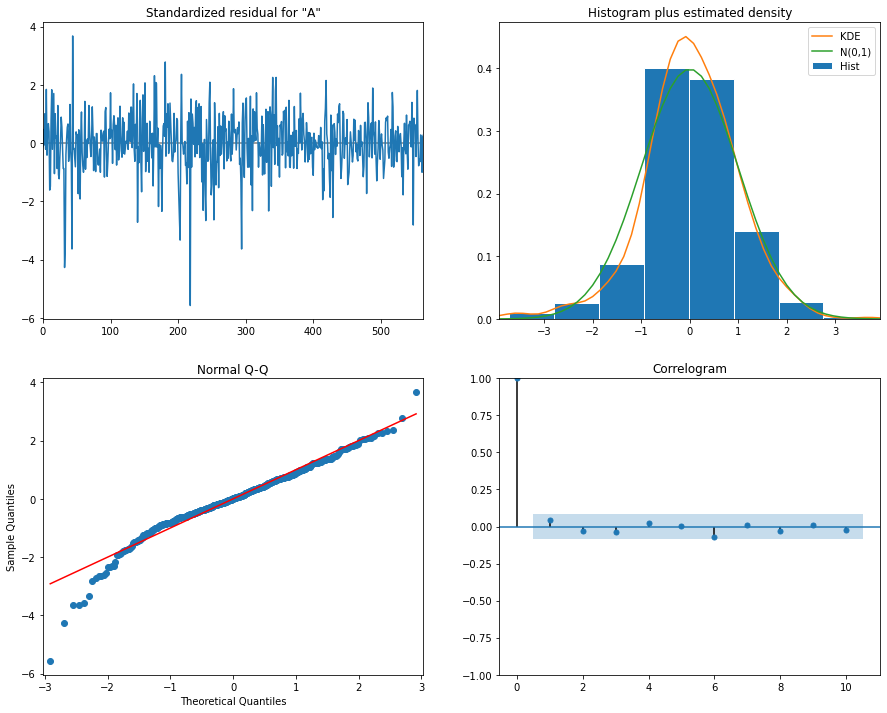

     lb_stat  lb_pvalue
1   0.086078   0.769224
2   0.110761   0.946125
3   0.111878   0.990375
4   0.116381   0.998371
5   0.256606   0.998381
6   0.367153   0.999101
7   0.863029   0.996746
8   0.924439   0.998682
9   0.945387   0.999553
10  0.973601   0.999848


In [13]:
### ARIMA model

mod=sm.tsa.statespace.SARIMAX(df.AdjDiv,order=(0,1,0),enforce_stationarity=False,
                                             enforce_invertibility=False)

results=mod.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15,12))
plt.show()



ljung = sm.stats.diagnostic.acorr_ljungbox(results.resid)
print(ljung)


#### The Diagnostic plots agree with our claim, and all the Box Ljung p-values are > 0.05. However, the Q-Q plot is highlighting some issues around skewness and kurtosis which we will investigate later with a Jarque Bera Test

#### We can also confirm our claim with a Python version of R's auto.arima function from pmdarima package

https://github.com/alkaline-ml/pmdarima

In [20]:
#!pip install pmdarima
import pmdarima as pm

auto= pm.auto_arima(df.AdjDiv)
print('AdjDiv')
print(auto)

auto2= pm.auto_arima(df.logreturn)
print('logreturn')
print(auto2)

AdjDiv
 ARIMA(0,1,0)(0,0,0)[0]          
logreturn
 ARIMA(0,0,0)(0,0,0)[0]          


#### Likewise, the auto.arima function affirms our claim from before. Infact, this isnt a surprise as an ARIMA(0,1,0) model is a random walk

An ARIMA(0,1,0) series when differenced once will become ARMA(0,0), which is uncorrelated random noise.

$$X_{i+1} - X_{i} =e_{i+1}$$
Then if $e_{i+1}$ is a sequence of centered, uncorrelated random variables,
$$X_{i+1}=X_{i}+e_{i+1}$$
Which is a random walk, aka a cumulative sum of an i.i.d. process


### Jarque Bera Test

Indicated by the Q-Q Plot from the diagnostics, we had some suspicions which are now confirmed about the skewness and kurtosis.

#### Over-Dispersed Data
Over-dispersed data has an increased number of outliers (i.e. the distribution has fatter tails than a normal distribution). Over-dispersed data is also known as having a leptokurtic distribution and as having positive excess kurtosis.

the smallest observations are smaller than you would expect from a normal distribution

the largest observations are larger than you would expect from a normal distribution

Since we have negative skewness, the probability of geƫng an outcome below the mean is
higher than the probability of achieving an outcome above the mean.


In [25]:
import scipy.stats as stats

jb_stat, p = stats.jarque_bera(df.logreturn)
print('stat=%.3f, p=%.3f' % (jb_stat, p))
if p > 0.05:
    print('Gaussian at the 0.05 significance level')
else:
    print('Not Gaussian at the 0.05 significane level')

kur = stats.kurtosis(df.logreturn)
print('Kurtosis is ',kur)

skew = stats.skew(df.logreturn)
print('Skewness is ',skew)    

stat=304.807, p=0.000
Not Gaussian at the 0.05 significane level
Kurtosis is  3.2880978731083568
Skewness is  -0.7268222523202506
